In [61]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

In [62]:
# -----------------------------
# 1) Load datasets (UserGrid only)
# -----------------------------
issues_path  = r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Issues 824.csv"
summary_path = r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Issues Summary 929.csv"
sprint_path  = r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Sprints 36.csv"

issues  = pd.read_csv(issues_path, on_bad_lines="skip", engine="python")
summary = pd.read_csv(summary_path, on_bad_lines="skip", engine="python")
sprints = pd.read_csv(sprint_path, on_bad_lines="skip", engine="python")

for df in [issues, summary, sprints]:
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]

In [63]:
# -----------------------------
# 2) Merge summary + issues + sprints safely
# -----------------------------
# merge on issue key
df = summary.merge(
    issues,
    left_on="issuekey",
    right_on="key",
    how="left",
    suffixes=("_summary", "_issue")
)
# merge sprints by sprintid
df = df.merge(sprints, on="sprintid", how="left", suffixes=("", "_spr"))

print("✅ Merged shape:", df.shape)

✅ Merged shape: (2259, 53)


In [64]:
# -----------------------------
# 3) Normalize important columns
# -----------------------------
def pick_col(df, *names, default=None):
    for n in names:
        if n in df.columns:
            return df[n]
    return default

df["assignee"]    = pick_col(df, "assignee_issue", "assignee_summary")
df["issuetype"]   = pick_col(df, "issuetype", default="Unknown")
df["status"]      = pick_col(df, "status_issue", "status_summary", default="Unknown")
df["priorityid"]  = pick_col(df, "priorityid", "priority", default=3)
df["storypoint"]  = pick_col(df, "storypoint", "currentstorypoint", "initialstorypoint", default=0)

df = df[df["assignee"].notna() & (df["assignee"] != "")]
df["priorityid"]  = pd.to_numeric(df["priorityid"], errors="coerce").fillna(3).astype(int)
df["storypoint"]  = pd.to_numeric(df["storypoint"], errors="coerce").fillna(0)

print("✅ Cleaned data:", df.shape)
print("Unique assignees:", df["assignee"].nunique())

✅ Cleaned data: (2090, 55)
Unique assignees: 13


In [65]:
# -----------------------------
# 4) Features
# -----------------------------
num_feats = ["storypoint", "priorityid"]
cat_feats = ["issuetype", "status"]
X = df[num_feats + cat_feats]
y = df["assignee"].astype(str)

In [66]:
# -----------------------------
# 5) Safe split (auto-handle rare classes)
# -----------------------------
from sklearn.model_selection import train_test_split

# Filter out classes that appear only once
counts = y.value_counts()
valid_assignees = counts[counts >= 2].index
X = X[y.isin(valid_assignees)]
y = y[y.isin(valid_assignees)]

print(f"✅ Filtered dataset: {len(X)} samples, {y.nunique()} assignees (≥ 2 samples each)")

# If still too small or uneven, fall back to non-stratified split
try:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
except ValueError as e:
    print("⚠️ Stratified split failed due to low-frequency classes. Falling back to random split.")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

print(f"✅ Split complete: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")


✅ Filtered dataset: 2090 samples, 13 assignees (≥ 2 samples each)
⚠️ Stratified split failed due to low-frequency classes. Falling back to random split.
✅ Split complete: Train=1463, Val=313, Test=314


In [67]:
# -----------------------------
# 6) Preprocessing
# -----------------------------
preproc = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler(with_mean=False))
    ]), num_feats),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("enc", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_feats)
])

In [68]:
from sklearn.model_selection import train_test_split
import numpy as np

# -------------------------------------------------
# 🧩 SAFE SPLITTER — handles rare classes gracefully
# -------------------------------------------------

# Filter out assignees with < 2 samples
counts = pd.Series(y_encoded).value_counts()
valid_classes = counts[counts >= 2].index
mask = np.isin(y_encoded, valid_classes)

X = X[mask]
y_encoded = y_encoded[mask]

print(f"✅ Filtered to {len(X)} samples, {len(valid_classes)} valid assignees (≥2 samples each)")

# Try stratified first, fallback to normal split if needed
try:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
except ValueError:
    print("⚠️ Not enough samples for stratified split — falling back to random split.")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

print(f"✅ Split complete → Train={len(X_train)} | Val={len(X_val)} | Test={len(X_test)}")


✅ Filtered to 2090 samples, 13 valid assignees (≥2 samples each)
⚠️ Not enough samples for stratified split — falling back to random split.
✅ Split complete → Train=1463 | Val=313 | Test=314


In [69]:
# -----------------------------
# 7) RandomForest
# -----------------------------
rf = Pipeline([
    ("prep", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced", n_jobs=-1))
])
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

In [70]:
# -----------------------------
# 8) XGBoost
# -----------------------------
xgb = Pipeline([
    ("prep", preproc),
    ("clf", XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)

# Convert predictions back to names for reporting
y_true_names = lbl.inverse_transform(y_test)
y_pred_names = lbl.inverse_transform(y_pred_xgb)



📊 Random Forest Results:
Top-1 Accuracy : 0.341
Top-3 Accuracy : 0.637
Macro F1-score : 0.310
              precision    recall  f1-score   support

           2       0.10      1.00      0.18         4
           3       0.50      0.17      0.25        48
           4       0.87      0.41      0.56        66
           5       0.14      0.38      0.21         8
           6       0.67      0.19      0.30        21
           7       0.00      0.00      0.00         1
           8       0.17      1.00      0.29        12
           9       0.50      1.00      0.67         3
          10       0.00      0.00      0.00        47
          11       0.67      0.17      0.28        46
          12       0.73      0.66      0.69        58

    accuracy                           0.34       314
   macro avg       0.39      0.45      0.31       314
weighted avg       0.55      0.34      0.37       314



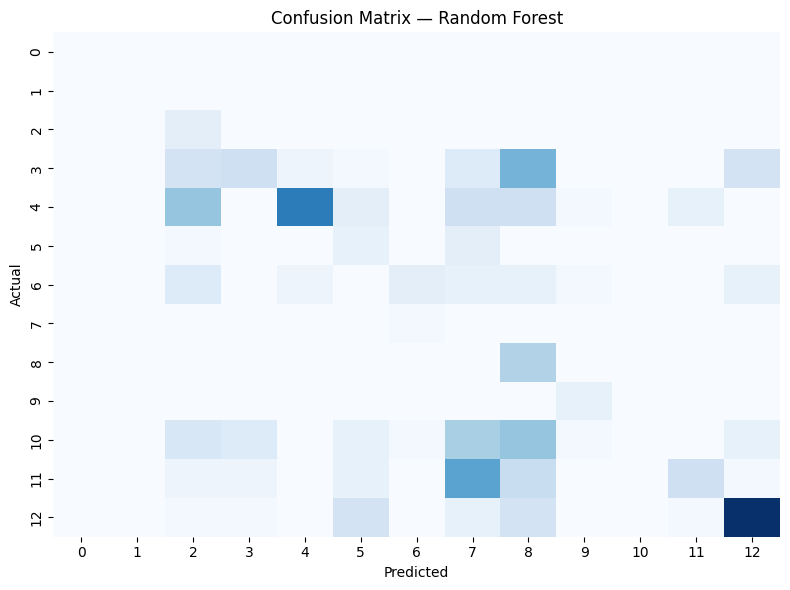


📊 XGBoost Results:
Top-1 Accuracy : 0.481
Top-3 Accuracy : 0.755
Macro F1-score : 0.296
                 precision    recall  f1-score   support

Brandon Shelley       0.00      0.00      0.00         4
  David Johnson       0.30      0.54      0.38        48
   George Reyes       0.59      0.68      0.63        66
   Jeffrey West       0.00      0.00      0.00         8
  Michael Russo       0.80      0.19      0.31        21
    Mike Dunker       0.00      0.00      0.00         1
    Rod Simpson       0.00      0.00      0.00        12
Senthil Kumar K       0.60      1.00      0.75         3
  Shawn Feldman       0.00      0.00      0.00        47
      Todd Nine       0.42      0.61      0.50        46
   ryan bridges       0.62      0.78      0.69        58

       accuracy                           0.48       314
      macro avg       0.30      0.35      0.30       314
   weighted avg       0.40      0.48      0.42       314



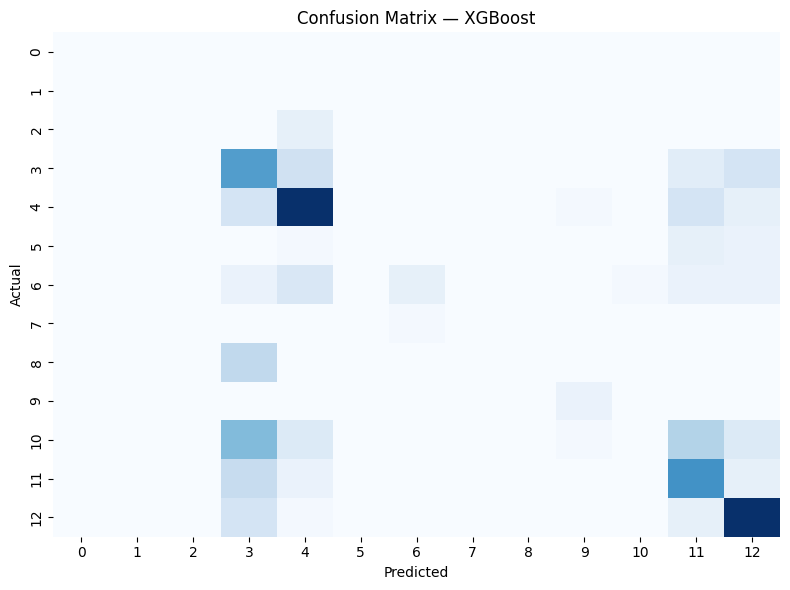

In [71]:
# -----------------------------
# 9) Evaluation
# -----------------------------
def evaluate(model_name, y_true, y_pred, y_proba, classes):
    top1 = accuracy_score(y_true, y_pred)
    top3 = top_k_accuracy_score(y_true, y_proba, k=3, labels=classes)
    f1 = f1_score(y_true, y_pred, average="macro")
    print(f"\n📊 {model_name} Results:")
    print(f"Top-1 Accuracy : {top1:.3f}")
    print(f"Top-3 Accuracy : {top3:.3f}")
    print(f"Macro F1-score : {f1:.3f}")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

evaluate("Random Forest", y_test, y_pred_rf, y_proba_rf, rf.named_steps["clf"].classes_)
evaluate("XGBoost", y_true_names, y_pred_names, y_proba_xgb, lbl.classes_)
